In [1]:
!pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
!pip install 'accelerate>=0.26.0'

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import evaluate
import torch
import ast

## ***Get Dataset - BigCodeBench***

In [4]:
dataset = load_dataset("bigcode/bigcodebench", split="v0.1.0_hf[:10]")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.62k [00:00<?, ?B/s]

v0.1.0_hf-00000-of-00001.parquet:   0%|          | 0.00/2.39M [00:00<?, ?B/s]

v0.1.1-00000-of-00001.parquet:   0%|          | 0.00/2.39M [00:00<?, ?B/s]

v0.1.2-00000-of-00001.parquet:   0%|          | 0.00/2.39M [00:00<?, ?B/s]

Generating v0.1.0_hf split:   0%|          | 0/1140 [00:00<?, ? examples/s]

Generating v0.1.1 split:   0%|          | 0/1140 [00:00<?, ? examples/s]

Generating v0.1.2 split:   0%|          | 0/1140 [00:00<?, ? examples/s]

## ***Initialize Models***

In [5]:
model_names = {                               #TODO : Change Model to check improvement
    "CodeLlama": "codellama/CodeLlama-7b-hf",
}

tokenizers = {}
models = {}

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for name, model_id in model_names.items():
    tokenizers[name] = AutoTokenizer.from_pretrained(model_id)
    models[name] = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16, device_map="cuda")
    #models[name] = models[name].to("cuda")

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/637 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [7]:
def load_model():
    model_id = "codellama/CodeLlama-7b-Instruct-hf"
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        device_map="cuda",
    )
    return tokenizer, model

## ***Feedback Model***

In [8]:
def generate_feedback(prompt, tokenizer, model):
  chat = [
      {
          "role": "system",
          "content": (
              "You are an expert programmer tasked with breaking down a coding task into a concise, step-by-step implementation plan. "
              "Your response must contain only a numbered list of actionable steps required to complete the task. "
              "Do not include explanations, descriptions, examples, or any other text outside the numbered steps."
          )
      },
      {
          "role": "user",
          "content": f"Coding task:\n{prompt}"
      }
  ]

  inputs = tokenizer.apply_chat_template(chat, return_tensors="pt").to("cuda")
  output = model.generate(input_ids=inputs, max_new_tokens=500, temperature=0.7, top_p=0.90)
  response = tokenizer.decode(output[0], skip_special_tokens=True)
  response_n = extract_numbered_statements(response, prompt)
  print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
  print(response_n)
  print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
  return response_n

import re

def extract_numbered_statements(text, initial_prompt):
    lines = text.splitlines()
    numbered_statements = [line.strip() for line in lines if re.match(r'^\d+\.', line.strip())]
    insertion_point = r"(Returns:\n)"
    numbered_statements = "\n   ".join(numbered_statements)
    # Add the subtasks string before the identified insertion point
    integrated_function = re.sub(
        insertion_point,
        r"Subtasks:\n    " + numbered_statements + "\n\n    Returns:\n",
        initial_prompt
    )
    return integrated_function



In [9]:
token, mod = load_model()

tokenizer_config.json:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/646 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [17]:
#[IMPORTANT : Run evaluation block before running this cell]

def generate_score(prompt, model, tokenizer, data, max_length=2000):
    n = 2#TODO : Set N based on your inplementation
    for _ in range(n):
      print(str(_) + "th iteration")
      # print("Prompt : " + prompt)
      # print("========================")
      inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
      output = model.generate(**inputs, max_length=max_length, top_p=0.9, do_sample=True)
      generated_code = tokenizer.decode(output[0], skip_special_tokens=True)
      # print("Generated Code : "+generated_code)
      # print("=======================")
      evaluation_result = evaluate_code_generation(generated_code, data['test'], ast.literal_eval(data['libs']))
      prompt = generate_feedback(prompt, token, mod) #TODO : Implement funtion partametrs for Reinforcement
    return evaluation_result["pass_ratio"]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


1
0th iteration


EE.EEEEE.E
ERROR: test_custom_list (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 13, in test_custom_list
  File "<string>", line 35, in task_func
  File "/usr/lib/python3.10/random.py", line 394, in shuffle
    x[i], x[j] = x[j], x[i]
TypeError: 'tuple' object does not support item assignment

ERROR: test_default_numbers (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 8, in test_default_numbers
  File "<string>", line 35, in task_func
  File "/usr/lib/python3.10/random.py", line 394, in shuffle
    x[i], x[j] = x[j], x[i]
TypeError: 'tuple' object does not support item assignment

ERROR: test_identical_elements (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 33, in test_identical_

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
import itertools
from random import shuffle

def task_func(numbers=list(range(1, 3))):
    """
    Calculates the average of the sums of absolute differences between each pair of consecutive numbers 
    for all permutations of a given list. Each permutation is shuffled before calculating the differences.

    Args:
    - numbers (list): A list of numbers. Default is numbers from 1 to 10.
    
    Subtasks:
    1. Import the necessary modules: `itertools` and `random`
   2. Define the `task_func` function with a default argument of `numbers=list(range(1, 3))`
   3. Calculate the average of the sums of absolute differences between each pair of consecutive numbers for all permutations of the given list
   4. Shuffle each permutation before calculating the differences
   5. Return the average of the sums of absolute differences for each shuffled permutation of the list
   6. Test the function with the example input `[1, 2, 3]` and ensure that the ou

FFFFEFFFFE
ERROR: test_large_list_with_seed (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 50, in test_large_list_with_seed
  File "/usr/lib/python3.10/unittest/case.py", line 876, in assertAlmostEqual
    diff = abs(first - second)
TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

ERROR: test_specific_value_with_seed (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 45, in test_specific_value_with_seed
  File "/usr/lib/python3.10/unittest/case.py", line 876, in assertAlmostEqual
    diff = abs(first - second)
TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

FAIL: test_custom_list (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 14, in test_cus

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
import itertools
from random import shuffle

def task_func(numbers=list(range(1, 3))):
    """
    Calculates the average of the sums of absolute differences between each pair of consecutive numbers 
    for all permutations of a given list. Each permutation is shuffled before calculating the differences.

    Args:
    - numbers (list): A list of numbers. Default is numbers from 1 to 10.
    
    Subtasks:
    1. Import the necessary modules: `itertools` and `random`
   2. Define the `task_func` function with a default argument of `numbers=list(range(1, 3))`
   3. Calculate the average of the sums of absolute differences between each pair of consecutive numbers for all permutations of the given list
   4. Shuffle each permutation before calculating the differences
   5. Return the average of the sums of absolute differences for each shuffled permutation of the list
   6. Test the function with the example input `[1, 2, 3]` and ensure that the ou

EEE
ERROR: test_generated_string_properties (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 6, in setUp
NameError: name 'string' is not defined

ERROR: test_negative_length (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 6, in setUp
NameError: name 'string' is not defined

ERROR: test_zero_length (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 6, in setUp
NameError: name 'string' is not defined

----------------------------------------------------------------------
Ran 3 tests in 0.003s

FAILED (errors=3)
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- th

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
import collections
import random
import string

def task_func(length=100):
    """
    Generate a random string of the specified length composed of uppercase and lowercase letters, 
    and then count the occurrence of each character in this string.

    Parameters:
    length (int, optional): The number of characters in the generated string. Default is 100.

    Subtasks:
    1. Import the necessary modules:
   2. Define the function `task_func` with a default parameter `length=100`:
   3. Generate a random string of the specified length using the `random` module:
   4. Count the occurrence of each character in the random string using the `collections.Counter` class:
   5. Return the dictionary of character counts:
   6. Test the function with a random seed to ensure reproducibility:

    Returns:
    dict: A dictionary where each key is a character from the generated string and the value 
            is the count of how many times that characte

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
import collections
import random
import string

def task_func(length=100):
    """
    Generate a random string of the specified length composed of uppercase and lowercase letters, 
    and then count the occurrence of each character in this string.

    Parameters:
    length (int, optional): The number of characters in the generated string. Default is 100.

    Subtasks:
    1. Import the necessary modules:
   2. Define the function `task_func` with a default parameter `length=100`:
   3. Generate a random string of the specified length using the `random` module:
   4. Count the occurrence of each character in the random string using the `collections.Counter` class:
   5. Return the dictionary of character counts:
   6. Test the function with a random seed to ensure reproducibility:

    Subtasks:
    1. Import the necessary modules:
   2. Define the function `task_func` with a default parameter `length=100`:
   3. Generate a random string of t

FEEEE
ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 13, in test_case_2
AttributeError: 'list' object has no attribute 'keys'

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 18, in test_case_3
AttributeError: 'list' object has no attribute 'values'

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 23, in test_case_4
AttributeError: 'list' object has no attribute 'values'

ERROR: test_case_5 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 28, in test_case_5
AttributeError: 'list' object has no attribute 'keys'

FAIL: test_cas

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
import random
import statistics

def task_func(LETTERS):
    """
    Create a dictionary in which keys are random letters and values are lists of random integers.
    The dictionary is then sorted by the mean of the values in descending order, demonstrating the use of the statistics library.
    
    Parameters:
        LETTERS (list of str): A list of characters used as keys for the dictionary.
    
    Subtasks:
    1. Import the `random` and `statistics` libraries using the following lines of code:
   2. Define a function `task_func` that takes a list of characters `LETTERS` as an argument.
   3. Create a dictionary `d` with the keys being the elements of `LETTERS` and the values being lists of random integers.
   4. Sort the dictionary `d` by the mean of the values in descending order using the `statistics.mean` function.
   5. Return the sorted dictionary `sorted_d`.
   6. Test the function by calling it with a list of characters and checkin

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
import random
import statistics

def task_func(LETTERS):
    """
    Create a dictionary in which keys are random letters and values are lists of random integers.
    The dictionary is then sorted by the mean of the values in descending order, demonstrating the use of the statistics library.
    
    Parameters:
        LETTERS (list of str): A list of characters used as keys for the dictionary.
    
    Subtasks:
    1. Import the `random` and `statistics` libraries using the following lines of code:
   2. Define a function `task_func` that takes a list of characters `LETTERS` as an argument.
   3. Create a dictionary `d` with the keys being the elements of `LETTERS` and the values being lists of random integers.
   4. Sort the dictionary `d` by the mean of the values in descending order using the `statistics.mean` function.
   5. Return the sorted dictionary `sorted_d`.
   6. Test the function by calling it with a list of characters and checkin

.....
----------------------------------------------------------------------
Ran 5 tests in 0.006s

OK
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:No

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
import random
import numpy as np

def task_func(LETTERS):
    """
    Create a dictionary where keys are specified letters and values are lists of random integers.
    Then calculate the mean of these integers for each key and return a dictionary of these means.

    Parameters:
        LETTERS (list of str): List of single-character strings to be used as keys in the output dictionary.
    
    Subtasks:
    1. Import the necessary libraries:
   2. Define the `task_func` function:
   3. Create a dictionary where keys are specified letters and values are lists of random integers:
   4. Calculate the mean of these integers for each key and return a dictionary of these means:
   5. Test the function with the given example:

    Returns:
        dict: A dictionary where each key is a letter from the input list and the value is the mean of 
              a randomly generated list of integers (with each list having 1 to 10 integers ranging from 0 to 10

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
import random
import numpy as np

def task_func(LETTERS):
    """
    Create a dictionary where keys are specified letters and values are lists of random integers.
    Then calculate the mean of these integers for each key and return a dictionary of these means.

    Parameters:
        LETTERS (list of str): List of single-character strings to be used as keys in the output dictionary.
    
    Subtasks:
    1. Import the necessary libraries:
   2. Define the `task_func` function:
   3. Create a dictionary where keys are specified letters and values are lists of random integers:
   4. Calculate the mean of these integers for each key and return a dictionary of these means:
   5. Test the function with the given example:

    Subtasks:
    1. Import the necessary libraries:
   2. Define the `task_func` function:
   3. Create a dictionary where keys are specified letters and values are lists of random integers:
   4. Calculate the mean of these int

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
from collections import Counter
import itertools

def task_func(d):
    """
    Count the occurrence of each integer in the values of the input dictionary, where each value is a list of integers,
    and return a dictionary with these counts. The resulting dictionary's keys are the integers, and the values are 
    their respective counts across all lists in the input dictionary.

    Parameters:
    d (dict): A dictionary where each key is a string and the value is a list of integers.

    Subtasks:
    1. Import the necessary modules:
   2. Define the function `task_func` that takes a dictionary `d` as input:
   3. Use the `Counter` class from the `collections` module to count the occurrence of each integer in the values of the input dictionary:
   4. Use the `dict` constructor to create a new dictionary with the counts as values and the integers as keys:
   5. Return the resulting dictionary:
   6. Test the function with the given example dict

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
from collections import Counter
import itertools

def task_func(d):
    """
    Count the occurrence of each integer in the values of the input dictionary, where each value is a list of integers,
    and return a dictionary with these counts. The resulting dictionary's keys are the integers, and the values are 
    their respective counts across all lists in the input dictionary.

    Parameters:
    d (dict): A dictionary where each key is a string and the value is a list of integers.

    Subtasks:
    1. Import the necessary modules:
   2. Define the function `task_func` that takes a dictionary `d` as input:
   3. Use the `Counter` class from the `collections` module to count the occurrence of each integer in the values of the input dictionary:
   4. Use the `dict` constructor to create a new dictionary with the counts as values and the integers as keys:
   5. Return the resulting dictionary:
   6. Test the function with the given example dict

EEEEE
ERROR: test_custom_letters (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 8, in setUp
NameError: name 'random' is not defined

ERROR: test_default_letters (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 8, in setUp
NameError: name 'random' is not defined

ERROR: test_empty_letters (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 8, in setUp
NameError: name 'random' is not defined

ERROR: test_known_values (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 8, in setUp
NameError: name 'random' is not defined

ERROR: test_uniform_values (builtins.TestCases)
------------------------

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
import random
import math

def task_func(LETTERS=[chr(i) for i in range(97, 123)]):
    """
    Create a dictionary where keys are letters from a predefined list LETTERS and values are lists of random integers.
    Then, calculates the population standard deviation for each list of integers and returns a dictionary of these values.

    The random integers for each key are generated within the range 0 to 100, and each list contains between 1 to 10 integers.

    Parameters:
        LETTERS (list of str, optional): A list of single-character strings to be used as keys in the output dictionary.
                                         Defaults to the lowercase English alphabets ['a', 'b', ..., 'z'].

    Subtasks:
    1. Import the necessary libraries:
   2. Define the `task_func` function with the following signature:
   3. Inside the function, create a dictionary with the letters from the input list `LETTERS` as keys and empty lists as values:
  

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
import random
import math

def task_func(LETTERS=[chr(i) for i in range(97, 123)]):
    """
    Create a dictionary where keys are letters from a predefined list LETTERS and values are lists of random integers.
    Then, calculates the population standard deviation for each list of integers and returns a dictionary of these values.

    The random integers for each key are generated within the range 0 to 100, and each list contains between 1 to 10 integers.

    Parameters:
        LETTERS (list of str, optional): A list of single-character strings to be used as keys in the output dictionary.
                                         Defaults to the lowercase English alphabets ['a', 'b', ..., 'z'].

    Subtasks:
    1. Import the necessary libraries:
   2. Define the `task_func` function with the following signature:
   3. Inside the function, create a dictionary with the letters from the input list `LETTERS` as keys and empty lists as values:
  

.EE.E
ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/usr/lib/python3.10/unittest/mock.py", line 1379, in patched
    return func(*newargs, **newkeywargs)
  File "<string>", line 21, in test_case_2
  File "<string>", line 31, in task_func
  File "/usr/lib/python3.10/genericpath.py", line 65, in getctime
    return os.stat(filename).st_ctime
FileNotFoundError: [Errno 2] No such file or directory: 'access.log.1'

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/usr/lib/python3.10/unittest/mock.py", line 1379, in patched
    return func(*newargs, **newkeywargs)
  File "<string>", line 30, in test_case_3
  File "<string>", line 31, in task_func
  File "/usr/lib/python3.10/genericpath.py", line 65, in getctime
    return os.stat(filename).st_ctime
FileNotFoundError: [Errno 2] No su

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
import os
import re

def task_func(pattern, log_dir='/var/log/'):
    """
    Find the latest log file in a specified directory that matches a given regex pattern.

    This function searches through all files in the specified directory, filters them based on the provided regex pattern, 
    and returns the path to the most recent log file based on modification time. If no files match the pattern or the directory 
    is empty, the function returns None.

    Parameters:
        pattern (str): The regex pattern to match the names of the log files.
        log_dir (str, optional): The directory to search for log files. Defaults to '/var/log/'.

    Subtasks:
    1. Import the `os` and `re` modules.
   2. Define the `task_func` function with two parameters: `pattern` and `log_dir`.
   3. Use the `os.listdir` function to get a list of all files in the `log_dir` directory.
   4. Use the `re.match` function to filter the list of files based on the `pa

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
import os
import re

def task_func(pattern, log_dir='/var/log/'):
    """
    Find the latest log file in a specified directory that matches a given regex pattern.

    This function searches through all files in the specified directory, filters them based on the provided regex pattern, 
    and returns the path to the most recent log file based on modification time. If no files match the pattern or the directory 
    is empty, the function returns None.

    Parameters:
        pattern (str): The regex pattern to match the names of the log files.
        log_dir (str, optional): The directory to search for log files. Defaults to '/var/log/'.

    Subtasks:
    1. Import the `os` and `re` modules.
   2. Define the `task_func` function with two parameters: `pattern` and `log_dir`.
   3. Use the `os.listdir` function to get a list of all files in the `log_dir` directory.
   4. Use the `re.match` function to filter the list of files based on the `pa

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
import csv
import collections
import operator

def task_func(csv_file_path):
    """
    Find the best-selling product from a given CSV file with sales data.

    This function parses a CSV file assumed to have a header followed by rows containing
    two columns: 'product' and 'quantity'. It computes the total sales per product and
    determines the product with the highest cumulative sales. The CSV file must include
    at least these two columns, where 'product' is the name of the product as a string
    and 'quantity' is the number of units sold as an integer.

    Args:
        csv_file_path (str): The file path to the CSV file containing sales data.

    Subtasks:
    1. Open the CSV file using the `csv` module.
   2. Use the `csv.DictReader` class to read the CSV file and create a dictionary for each row.
   3. Use the `collections.defaultdict` class to create a dictionary to store the total sales for each product.
   4. Iterate over the 

EEEEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in setUp
NameError: name 'os' is not defined

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in setUp
NameError: name 'os' is not defined

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in setUp
NameError: name 'os' is not defined

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in setUp
NameError: name 'os' is not defined

ERROR: test_case_5 (builtins.TestCases)
----------------------------------------------------------------------
Trace

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
import csv
import collections
import operator

def task_func(csv_file_path):
    """
    Find the best-selling product from a given CSV file with sales data.

    This function parses a CSV file assumed to have a header followed by rows containing
    two columns: 'product' and 'quantity'. It computes the total sales per product and
    determines the product with the highest cumulative sales. The CSV file must include
    at least these two columns, where 'product' is the name of the product as a string
    and 'quantity' is the number of units sold as an integer.

    Args:
        csv_file_path (str): The file path to the CSV file containing sales data.

    Subtasks:
    1. Open the CSV file using the `csv` module.
   2. Use the `csv.DictReader` class to read the CSV file and create a dictionary for each row.
   3. Use the `collections.defaultdict` class to create a dictionary to store the total sales for each product.
   4. Iterate over the 

EEEEEEE
ERROR: test_case_1 (builtins.TestCases)
Single tuple with small integers as strings
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 7, in test_case_1
  File "<string>", line 33, in task_func
TypeError: int() argument must be a string, a bytes-like object or a real number, not 'tuple'

ERROR: test_case_2 (builtins.TestCases)
Multiple tuples with small integers as strings
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 13, in test_case_2
  File "<string>", line 33, in task_func
TypeError: int() argument must be a string, a bytes-like object or a real number, not 'tuple'

ERROR: test_case_3 (builtins.TestCases)
Single tuple with larger integers as strings
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 20, in test_case_3
  File "<string>",

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
from collections import Counter
import itertools
from random import randint

def task_func(T1, RANGE=100):
    """
    Convert elements in 'T1' to integers and create a list of random integers where the number of integers 
    is determined by the sum of the integers in `T1`. Random integers are generated between 0 and `RANGE` 
    (default is 100). Count the occurrences of each number in the generated list using a Counter.
    
    Parameters:
    T1 (tuple of tuples): Each inner tuple contains string representations of numbers that are converted to integers.
    RANGE (int, optional): The upper limit for the random number generation. Defaults to 100.
    
    Subtasks:
    1. Import the necessary libraries:
   2. Define the `task_func` function:
   3. Convert the elements in `T1` to integers:
   4. Create a list of random integers where the number of integers is determined by the sum of the integers in `T1`:
   5. Count the occurrences of each 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
from collections import Counter
import itertools
from random import randint

def task_func(T1, RANGE=100):
    """
    Convert elements in 'T1' to integers and create a list of random integers where the number of integers 
    is determined by the sum of the integers in `T1`. Random integers are generated between 0 and `RANGE` 
    (default is 100). Count the occurrences of each number in the generated list using a Counter.
    
    Parameters:
    T1 (tuple of tuples): Each inner tuple contains string representations of numbers that are converted to integers.
    RANGE (int, optional): The upper limit for the random number generation. Defaults to 100.
    
    Subtasks:
    1. Import the necessary libraries:
   2. Define the `task_func` function:
   3. Convert the elements in `T1` to integers:
   4. Create a list of random integers where the number of integers is determined by the sum of the integers in `T1`:
   5. Count the occurrences of each 

EEEEEEEE
ERROR: test_case_1 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 23, in test_case_1
  File "<string>", line 37, in task_func
TypeError: 'Axes' object is not subscriptable

ERROR: test_case_2 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 45, in test_case_2
  File "<string>", line 37, in task_func
TypeError: 'Axes' object is not subscriptable

ERROR: test_case_3 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<string>", line 63, in test_case_3
  File "<string>", line 37, in task_func
TypeError: 'Axes' object is not subscriptable

ERROR: test_case_4 (builtins.TestCases)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<strin

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def task_func(list_of_pairs):
    """
    Create a Pandas DataFrame from a list of pairs and visualize the data using a bar chart.
    - The title of the barplot should be set to 'Category vs Value'`.

    Parameters:
    list_of_pairs (list of tuple): Each tuple contains:
        - str: Category name.
        - int: Associated value.

    Subtasks:
    1. Import the necessary libraries:
   2. Define the `task_func` function:
   3. Create a Pandas DataFrame from the list of pairs:
   4. Set the title of the barplot to 'Category vs Value':
   5. Return the DataFrame and the Axes object:
   6. Test the function with an example input:

    Returns:
    tuple:
        - DataFrame: A pandas DataFrame with columns 'Category' and 'Value'.
        - Axes: A matplotlib Axes displaying a bar chart of categories vs. values.

    Requirements:
    - pandas
    - matplotlib.pyplot
   

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def task_func(list_of_pairs):
    """
    Create a Pandas DataFrame from a list of pairs and visualize the data using a bar chart.
    - The title of the barplot should be set to 'Category vs Value'`.

    Parameters:
    list_of_pairs (list of tuple): Each tuple contains:
        - str: Category name.
        - int: Associated value.

    Subtasks:
    1. Import the necessary libraries:
   2. Define the `task_func` function:
   3. Create a Pandas DataFrame from the list of pairs:
   4. Set the title of the barplot to 'Category vs Value':
   5. Return the DataFrame and the Axes object:
   6. Test the function with an example input:

    Subtasks:
    1. Import the necessary libraries:
   2. Define the `task_func` function:
   3. Create a Pandas DataFrame from the list of pairs:
   4. Set the title of the barplot to 'Category vs Value':
   5. Return the DataFrame and the A

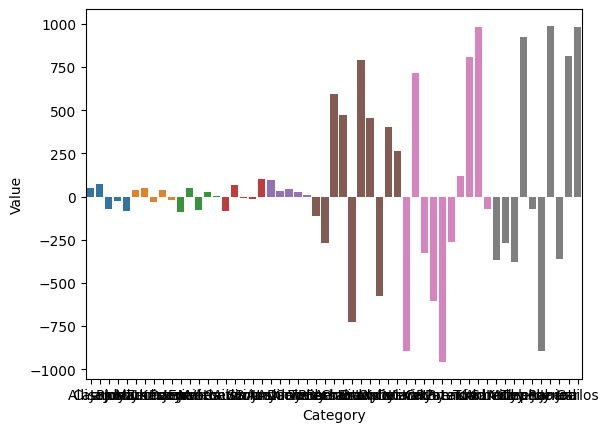

In [18]:
generated_scores = {name: [] for name in model_names}
i = 0
for example in dataset:
    i+=1
    print(i)
    prompt = example["complete_prompt"]
    for model_name in model_names:
        generated_score = generate_score(prompt, models[model_name], tokenizers[model_name], example)
        generated_scores[model_name].append(generated_score)

## ***Evaluation***

In [ ]:
# # Evaluation Setup with BLEU (or CodeBLEU if available)
# bleu_metric = evaluate.load("bleu")

# # Prepare reference code for evaluation
# references = [example["canonical_solution"] for example in dataset]

# # Evaluate each model's generated code against the reference code
# evaluation_scores = {}
# for model_name, codes in generated_codes.items():
#     bleu_score = bleu_metric.compute(predictions=codes, references=references)
#     evaluation_scores[model_name] = bleu_score["bleu"]
#     print(f"{model_name} BLEU Score:", bleu_score["bleu"])

# # Print final evaluation summary
# print("\n=== Evaluation Summary ===")
# for model_name, score in evaluation_scores.items():
#     print(f"{model_name} BLEU Score: {score:.4f}")

In [11]:
import unittest
from unittest.mock import patch

def evaluate_code_generation(generated_code, test_cases_code, libraries):
    """
    Dynamically evaluates the generated code based on pass ratio and executability.

    Parameters:
    - generated_code: A string containing the code to be evaluated.
    - test_cases_code: A string containing the test cases to be executed.
    - libraries: A list of library names to import and make available in the execution context.

    Returns:
    - A dictionary containing 'pass_ratio', 'executability', and 'errors'.
    """

    # Prepare a local namespace for executing the generated code
    local_namespace = {}
    error_messages = []

    # Import libraries dynamically and add them to the namespace
    for lib in libraries:
        try:
            # Import each library and add it to the local namespace
            local_namespace[lib] = __import__(lib)
        except ImportError as e:
            error_messages.append(f"Error importing {lib}: {e}")
            return {
                'pass_ratio': 0,
                'executability': False,
                'errors': error_messages
            }

    try:
        # Execute the generated code in the provided namespace
        exec(generated_code, local_namespace, local_namespace)
        executability = True
    except Exception as e:
        error_messages.append(f"Execution Error: {e}")
        executability = False

    if not executability:
        return {
            'pass_ratio': 0,
            'executability': executability,
            'errors': error_messages
        }

    # Add task_func to local_namespace so it can be accessed by tests
    task_func = local_namespace.get('task_func')

    if not task_func:
        error_messages.append("task_func is not defined in the generated code.")
        return {
            'pass_ratio': 0,
            'executability': False,
            'errors': error_messages
        }

    # Dynamically create a TestCase class from the provided test cases code
    try:
        exec(test_cases_code, {'task_func': task_func, 'patch': patch}, local_namespace)
    except Exception as e:
        error_messages.append(f"Test case execution error: {e}")
        return {
            'pass_ratio': 0,
            'executability': False,
            'errors': error_messages
        }

    # Extract the TestCase class from the local namespace
    TestClass = local_namespace.get('TestCases')

    if not TestClass:
        error_messages.append("TestCases class not found in provided test cases code.")
        return {
            'pass_ratio': 0,
            'executability': False,
            'errors': error_messages
        }

    # Define a custom test suite
    class CustomTestSuite(unittest.TestSuite):
        def run(self, result, debug=False):
            super().run(result, debug)
            return result

    # Run the tests using unittest framework
    suite = CustomTestSuite()
    suite.addTest(unittest.makeSuite(TestClass))

    runner = unittest.TextTestRunner()

    # Capture results
    result = runner.run(suite)

    # Calculate pass ratio
    pass_ratio = (result.testsRun - len(result.failures) - len(result.errors)) / result.testsRun if result.testsRun > 0 else 0

    # Collect errors from test results
    for failure in result.failures + result.errors:
        error_messages.append(str(failure))

    # Clear the local namespace after execution
    local_namespace.clear()

    return {
        'pass_ratio': pass_ratio,
        'executability': len(result.errors) == 0,
        'errors': error_messages
    }

In [16]:
# Example usage with dynamic inputs and libraries list
generated_code = """
import itertools
from random import shuffle

def task_func(numbers=list(range(1, 11))):
    permutations = list(itertools.permutations(numbers))
    sum_diffs = 0

    for perm in permutations:
        perm = list(perm)
        shuffle(perm)
        diffs = [abs(perm[i] - perm[i+1]) for i in range(len(perm)-1)]
        sum_diffs += sum(diffs)

    avg_sum_diffs = sum_diffs / len(permutations) if permutations else 0

    return avg_sum_diffs
"""

test_cases_code = """
import unittest

class TestCases(unittest.TestCase):

    def test_default_numbers(self):
        result = task_func()
        self.assertIsInstance(result, float)
        self.assertGreater(result, 0)

# Additional tests omitted for brevity...
"""

# List of libraries to import and use within exec()
libraries_to_import = []

# Evaluate the generated code with dynamic inputs and specified libraries
evaluation_result = evaluate_code_generation(generated_code, test_cases_code, libraries_to_import)
print(evaluation_result)

.
----------------------------------------------------------------------
Ran 1 test in 23.191s

OK


{'pass_ratio': 1.0, 'executability': True, 'errors': []}


In [ ]:
#TODO : Implement a function to average teh scores from each list in generate_score which is sthe final score of the model

In [21]:
average = sum(generated_scores['CodeLlama']) / len(generated_scores['CodeLlama'])

In [20]:
average

0.0

In [19]:
generated_scores

{'CodeLlama': [0.0, 0, 0, 0, 0, 0, 0, 0.0, 0, 0]}